In [1]:
#%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.ndimage import find_objects
from matplotlib.colors import Normalize
from src.cpm_basic import CellularPottsModel
from scipy.signal import convolve2d
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pickle
from skimage.measure import regionprops, label, perimeter as measure_perimeter
import pandas as pd

# Time Development 

In [2]:
n_cells=38
n_types=2 
T=26 
L=100
C_p=1
adhessions= np.array([[0, 0.2, 0.2],  
                      [0.2, 10, 20],
                      [0.2, 20, 10]]) 
volume_coefficient= np.array([0, 10, 10])
lattice_type="prerun"
object_volumes=None # Is default set in the CPM class if none
periodic=False

In [3]:
init = ["hex", "prerun", "circle"]
energies = []

for i in init:
    cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient,
                             adhessions=adhessions, lattice_type=i, object_volumes=object_volumes, periodic=periodic)
    energy = cpm.run_time_development_sim(steps=500000, interval=1000)
    energies.append(energy)

100%|██████████| 500000/500000 [02:07<00:00, 3913.55it/s]


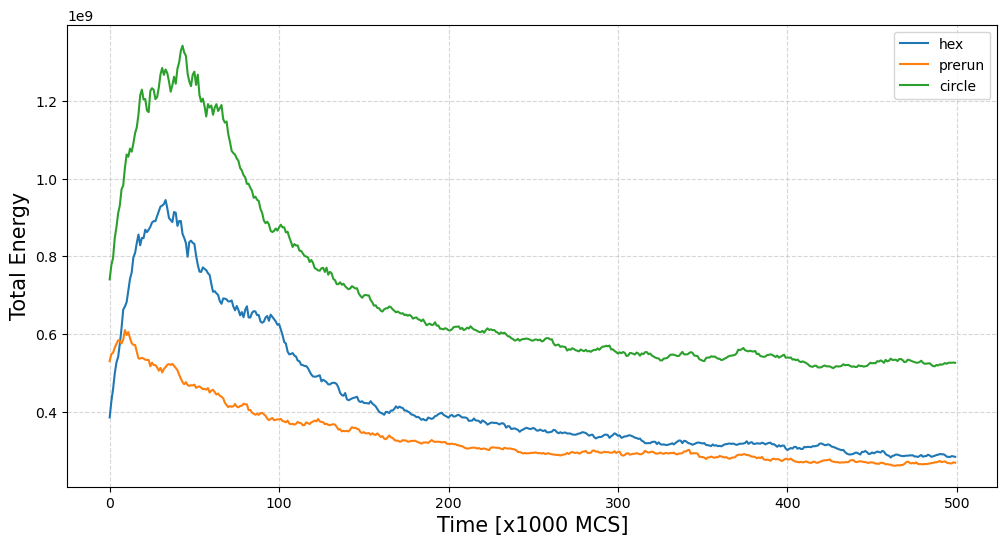

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))


for i, energy in enumerate(energies):
    ax.plot(energy, label=init[i])
ax.set_xlabel("Time [x1000 MCS]", fontsize=15)
ax.set_ylabel("Total Energy", fontsize=15)
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
plt.show()

# Varying Area and Perimeter coefficient


$$
\lambda = \frac{\lambda'}{J}
$$

$$
\beta = \frac{\beta'}{J}
$$


In [5]:
n_cells=38
n_types=2 
T=26 
L=100
J = 10
adhessions= np.array([[0, 0.2, 0.2],  
                      [0.2, J, J],
                      [0.2, J, J]]) 
volume_coefficient= np.array([0, 10, 10])
C_p=1
lattice_type="hex"
object_volumes=None # Is default set in the CPM class if none
periodic=False

In [6]:
lambda_values = [0, J, J*5, J*15]  # Area coefficient values
beta_values = [0, J, J*5, J*15]  # Perimeter coefficient values
results = []
types = []
for lambda_v in lambda_values:
    row = []
    row_type = []
    for beta_v in beta_values:
        volume_coefficient= np.array([0, lambda_v, lambda_v])
        C_p=beta_v
        cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient,
                                 adhessions=adhessions, lattice_type=lattice_type, object_volumes=object_volumes, periodic=periodic)
        M = cpm.run_a_sim(steps=220000)
        row.append(M)
        row_type.append(cpm.tau)
    results.append(row)
    types.append(row_type)

with open('saves/grids_hex.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('saves/types_hex.pkl', 'wb') as f:
    pickle.dump(types, f)

100%|██████████| 220000/220000 [00:30<00:00, 7231.42it/s]


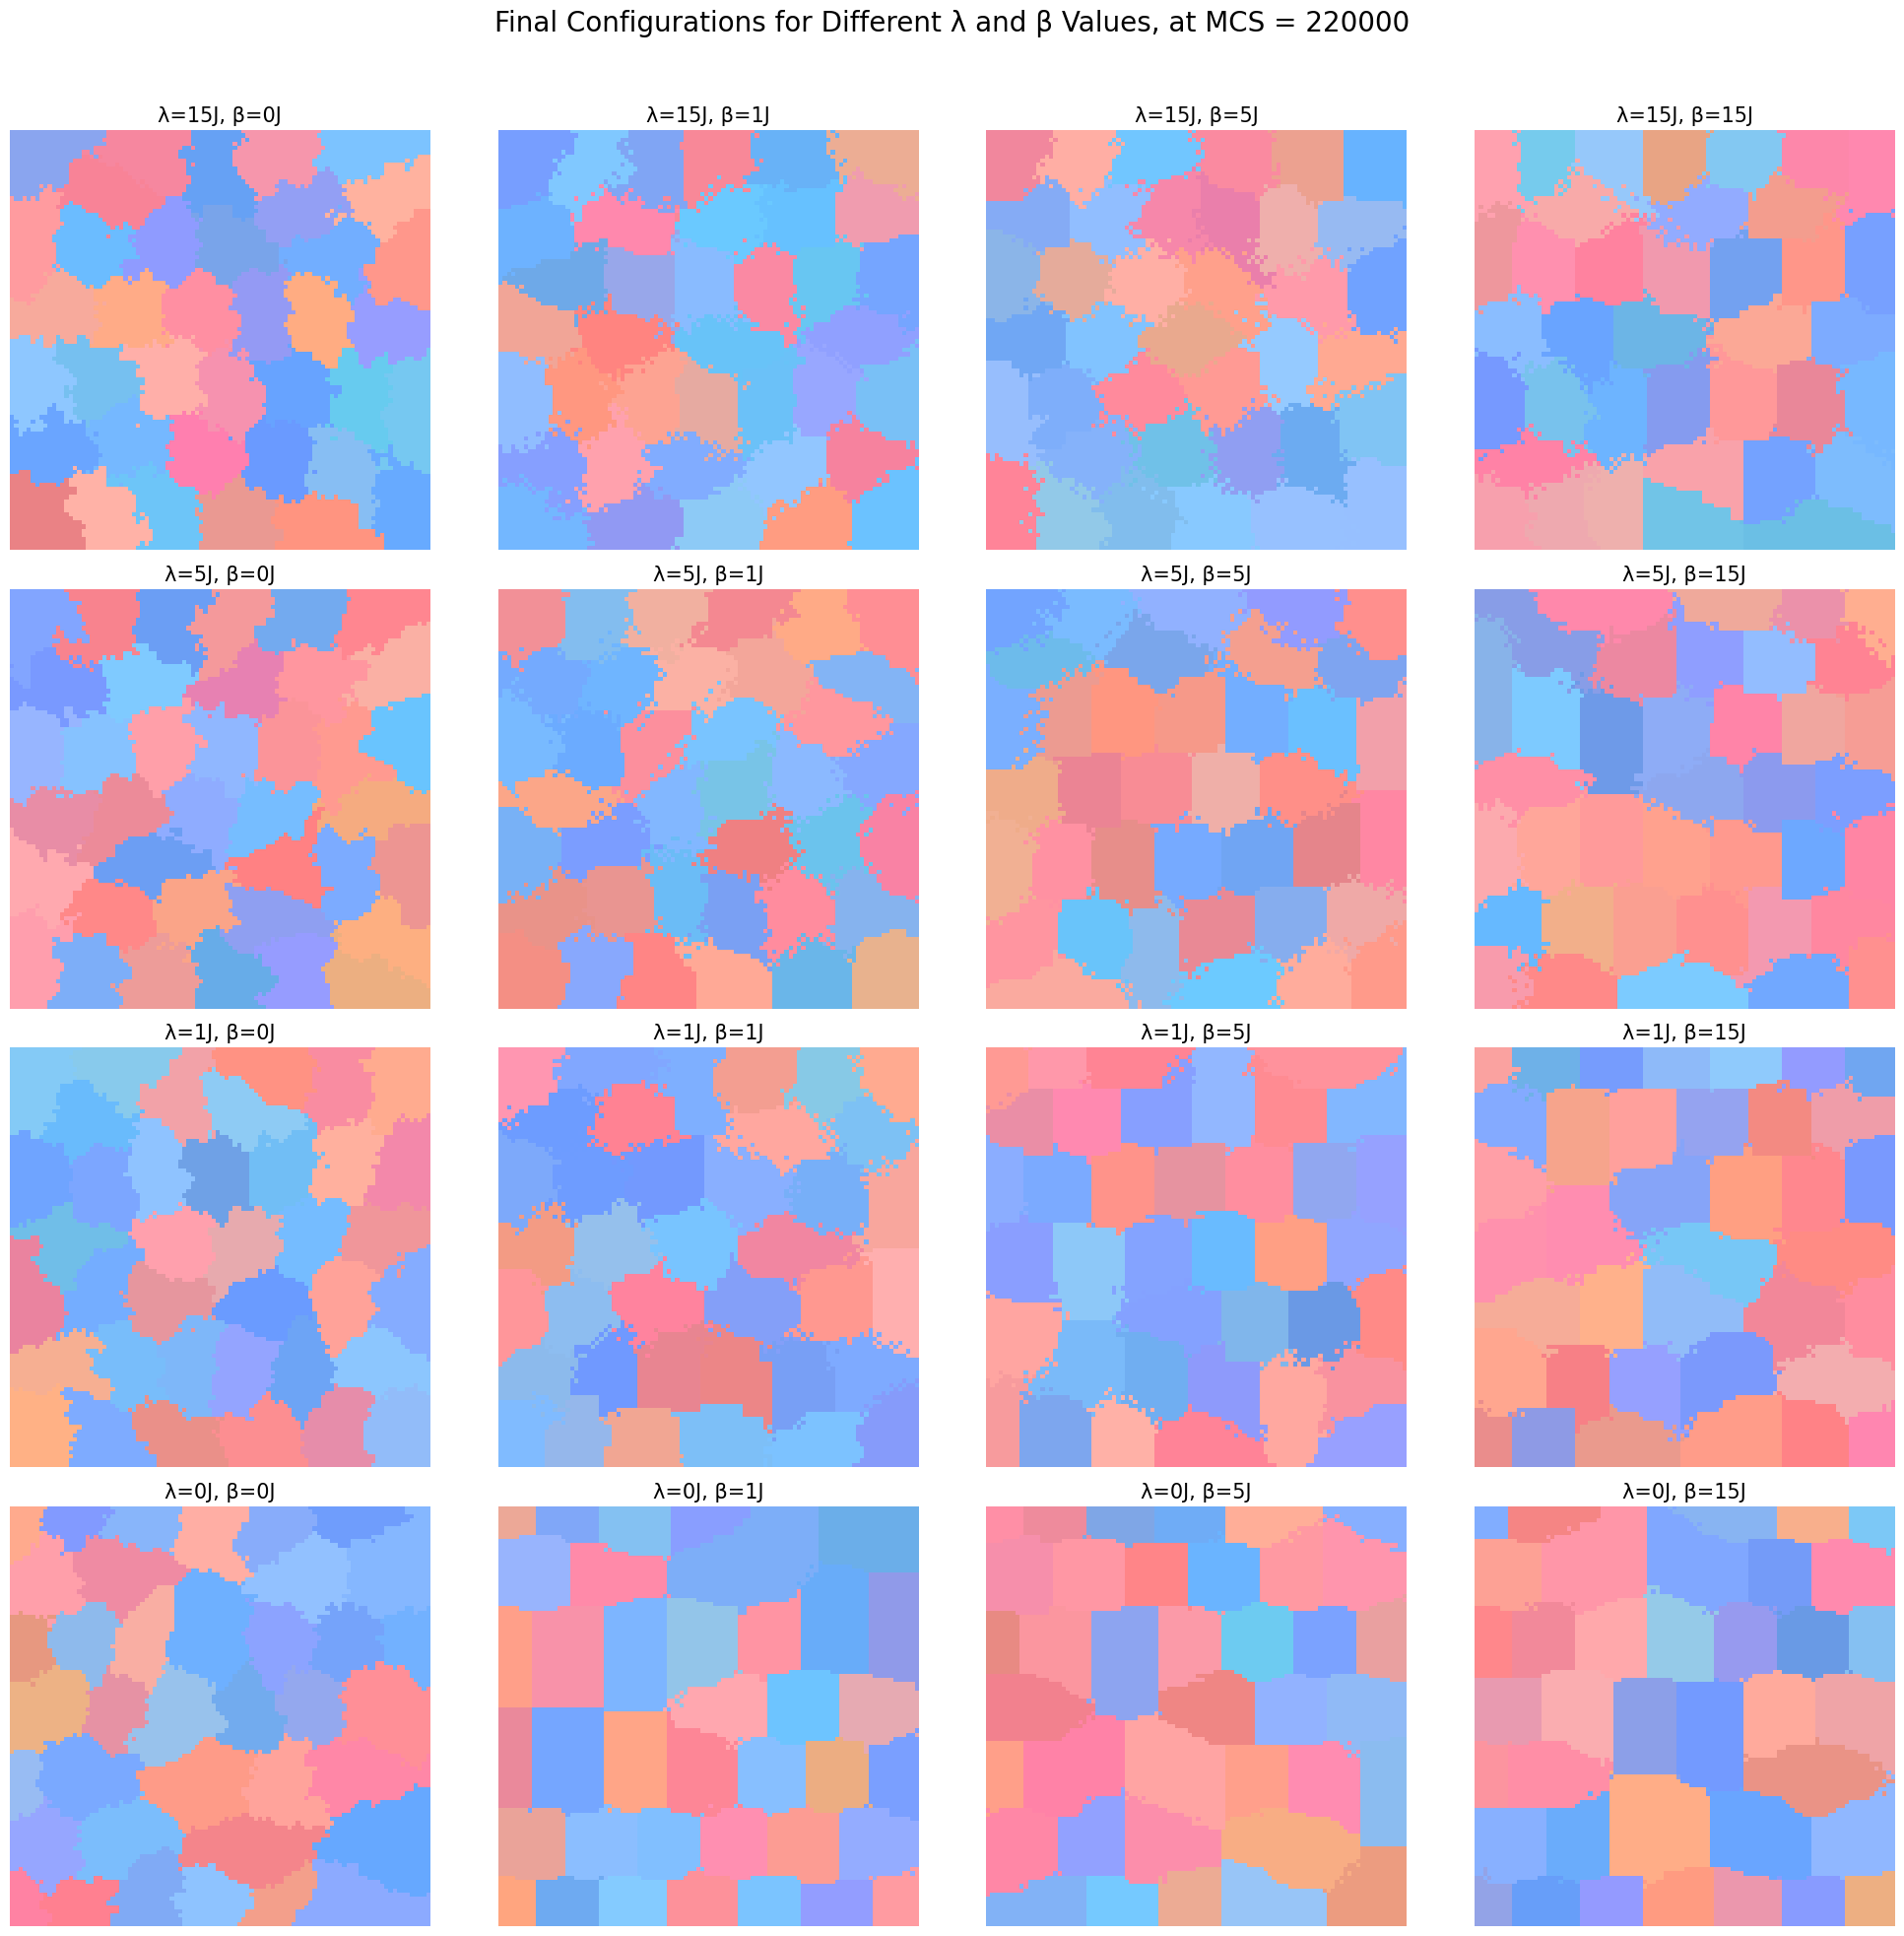

In [7]:
lambda_values = [0, J, J*5, J*15]  # Area coefficient values
beta_values = [0, J, J*5, J*15]  # Perimeter coefficient values

with open('saves/grids_hex.pkl', 'rb') as f:
    grids = pickle.load(f)
with open('saves/types_hex.pkl', 'rb') as f:
    types = pickle.load(f)

def color_code_cells(grid, type_cell):
    """
    Function that color code each cell based on its type with small random variations.
    Only takes two types plus background (0).
    """
    # Define base colors for each type (as RGB)
    type_base_colors = {
        0: np.array([1, 1, 1]),         # white for background
        1: np.array([0.5, 0.7, 1]),     # blue-ish for type 1
        2: np.array([1.0, 0.6, 0.6])      # red-ish for type 2
    }
    unique_cells = np.unique(grid)
    # Build an array of base colors for each unique cell
    base_colors = np.array([type_base_colors[type_cell[cell]] for cell in unique_cells])
    variations = (np.random.rand(len(unique_cells), 3) - 0.5) * 0.2

    # Cells with id 0 get no variation
    zero_mask = (unique_cells == 0)
    variations[zero_mask] = 0.0

    # Final colors for each unique cell
    all_colors = np.clip(base_colors + variations, 0, 1)
    # Map: cell_id → row index in unique_cells array
    cell_to_index = {cell: idx for idx, cell in enumerate(unique_cells)}
    # Build an index array matching A
    index_grid = np.vectorize(cell_to_index.get)(grid)

    # Build final color grid (vectorized gather)
    color_grid = all_colors[index_grid]
    return color_grid



fig, ax = plt.subplots(len(lambda_values), len(beta_values), figsize=(20, 20))

n_lambda = len(lambda_values)
n_beta = len(beta_values)

for i in range(n_lambda):
    for j in range(n_beta):
        row = n_lambda - 1 - i   # invert row index
        col = j
        color_grid = color_code_cells(grids[i][j], types[i][j])

        ax[row, col].imshow(color_grid)
        ax[row, col].set_title(
            f"λ={int(lambda_values[i]/J)}J, β={int(beta_values[j]/J)}J", fontsize=15
        )
        ax[row, col].axis('off')
fig.suptitle("Final Configurations for Different λ and β Values, at MCS = 220000", fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
M=np.array([[0, 0, 0, 0, 1 ], 
            [0, 1, 1, 0, 0 ], 
            [0, 1, 1, 0, 1 ], 
            [1, 1, 0, 2, 2 ], 
            [0, 0, 0, 2, 2 ]])

measure_perimeter(M==1, neighborhood=8)

6.207106781186548